# Boosting  
对于一个复杂任务，将多个专家的判断进行适当的总和得出的判断，要比其中任何一个专家单独的判断号

AdaBoost模型是弱分类器的线性组合  
$$f(x)=\sum_{m=1}^M\alpha_mG_m(x)$$

最终分类器  
$$G(x)=sign(f(x))=sign(\sum_{m=1}^M\alpha_mG_m(x))$$

**主要思想**  
每次迭代训练一个基本分类器，在每次迭代中，提高被前一轮弱分类器错误分类样本的权值，降低被正确分类的样本权值    
采取加权多数表决的方法组合各若分类器，加大分类误差小的分类器的权值，减小分类误差大的分类器的权值

**算法**  

1.初始化训练数据$(x_1,x_2,...,x_N)$权值  
$$D_1= (w_{11},w_{12},...,w_{1N})$$  
$w_{1i}=\frac{1}{N}, i=1,2,...,N$  

2.对有权值的数据经行训练，得到模型$G_m$（初始模型为{G_1}）

3.算{G_m}的分类误差率    
$$e_m=\sum_{i=1}^NP(G_m(x_i)!=y_i)=\sum_{i=1}^Nw_{mi}I(G_m(x_i)!=y_i)$$  

4.计算$G_m(x)的系数$  
 $$\alpha_m=\frac{1}{2}log\frac{1-e_m}{e_m}$$  
 log为自然对数，当$e_m$小于0.5，$\alpha$大于0，$\alpha$随着$e_m$的减小而增大   
5.更新数据集权值  
$$D_{m+1}=(w_{m+1,1},...,w_{m+1,i},...,w_{m+1,N})$$  

$$w_{m+1,i} = \frac{w_{mi}}{Z_m}exp(-\alpha_my_iG_m(x_i))$$  
$Z_m$ 是规范化因子，使$D_m+1$称为概率  

$$Z_m = \sum_{i=1}^Nw_{wi}exp(-\alpha_my_iG_m(x_i))$$ 

6.构成基本分类器  
$$f(x)=\sum_{m=1}^M\alpha_mG_m(x)$$
最终分类器  
$$G(x)=sign(f(x))=sign(\sum_{m=1}^M\alpha_mG_m(x))$$

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
df.head()

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


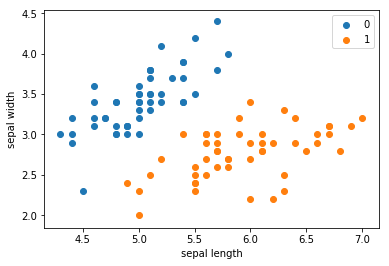

In [2]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:,[0,1]], data[:,-1]
y = np.array([1 if i == 1 else -1 for i in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=0.1):
        self.n_clf = n_estimators 
        self.lr = learning_rate
        
        
    def init(self, X, Y):
        self.X = X
        self.Y = Y
        self.M, self.N = X.shape
        
        # 弱分类器数据和集合
        self.clf_sets = []
        
        # 初始化weight
        self.weights = [1.0/self.M] * self.M
        
        # G(x)系数
        self.alpha = []
        
    def _G(self, features, labels, weights):
        # 这里features是指不同样本在同一维度（特征）上的数据
        
        m = len(features) # 数据量
        error = 10000.0 # 设初始损失无限大
        best_v = 0.0  # 最好的分割点
        features_min = min(features)
        features_max = max(features)
        n_step = (features_max-features_min+self.lr) //self.lr  # 将特征数值范围分割
        direct = 'positive' # x大于v时 取1还是小于是取1
        compare_array = None # 用于记录根据v分割label,v左边是1右边是-1或者左边是-1右边是1
        for i in range(1, int(n_step)):
            v = features_min + self.lr*i
            
            if v not in features:
                compare_array_positive = np.array([1 if features[k] > v else -1 for k in range(m)])
                
                weight_error_positive = sum([weights[k] for k in range(m) if compare_array_positive[k]!=labels[k]])
                
                compare_array_nagetive = np.array([-1 if features[k] > k else 1 for k in range(m)])
                
                weight_error_nagetive = sum([weights[k] for k in range(m) if compare_array_nagetive[k]!=labels[k]])
                
                # 选择误差小的方向
                if weight_error_positive < weight_error_nagetive:
                    weight_error = weight_error_positive
                    _compare_array = compare_array_positive
                    direct = 'positive'
                else:
                    weight_error = weight_error_nagetive
                    _compare_array = compare_array_nagetive
                    direct = 'nagetive'
                    
                if weight_error < error:
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v
        return best_v, direct, error, compare_array
            
    # 计算alpha
    def _alpha(self, error):
        return 0.5 * np.log((1-error)/error)
    
    def _Z(self, weight, a, clf):
        return sum([weight[i] * np.exp(-1 * a * self.Y[i] * clf[i]) for i in range(self.M)])
    
    def _w(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i] * np.exp(-1 * a * self.Y[i] * clf[i]) / Z
            
    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1
        else:
            return -1 if x > v else 1
    
    def fit(self, X, y):
        self.init(X, y)
        
        for i in range(self.n_clf):
            best_clf_error, best_v, clf_result = 10000, None, None
            # 根据特征维度，选择误差最小的
            for j in range(self.N):
                features = self.X[:, j]
                v, direct, error, compare_array = self._G(features, self.Y, self.weights)
                
                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j
                    
                if best_clf_error == 0:
                    break
            
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            
            self.clf_sets.append((axis, best_v, final_direct))
            Z = self._Z(self.weights, a, clf_result)
            self._w(a, clf_result, Z)
            
    def predict(self, x):
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = x[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
            
        # sign函数
        return 1 if result > 0 else -1
    
    
    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            x = X_test[i]
            if self.predict(x) == y_test[i]:
                right_count += 1
        
        return right_count / len(X_test)
    
                
    

In [5]:
# 例8.1
X = np.arange(10).reshape(10, 1)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

clf = AdaBoost(3)
clf.fit(X, y)

In [6]:
clf = AdaBoost(100, learning_rate=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6

### sklearn

In [7]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


1.0